Lc: 3.9645 um, Resolution: 3964.51 nm
Merging and filtering domains...
Initial Reduce: 30000 -> 20001 domains
Original segments: 30000, Final domains: 8883
Min width after filtering: 1.9823e+00 um
Running simulation...
Simulating Ideal Target...


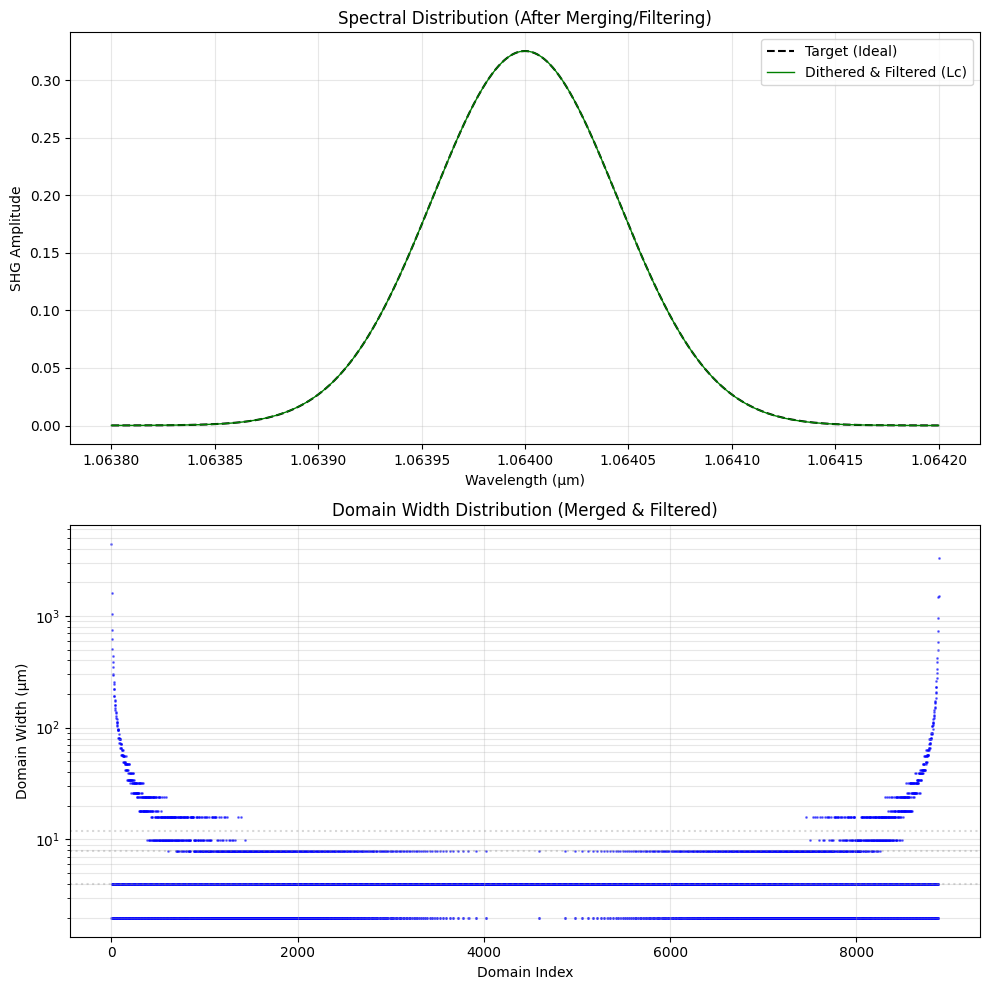

In [1]:
import matplotlib.pyplot as plt
import numpy as np

SELLMEIER_PARAMS = {
    "a": np.array([4.5615, 0.08488, 0.1927, 5.5832, 8.3067, 0.021696]),
    "b": np.array([4.782e-07, 3.0913e-08, 2.7326e-08, 1.4837e-05, 1.3647e-07]),
}


def sellmeier_n_eff(wl: np.ndarray, temp: float) -> np.ndarray:
    f = (temp - 24.5) * (temp + 24.5 + 2.0 * 273.16)
    lambda_sq = wl**2
    a, b = SELLMEIER_PARAMS["a"], SELLMEIER_PARAMS["b"]
    n_sq = (
        a[0]
        + b[0] * f
        + (a[1] + b[1] * f) / (lambda_sq - (a[2] + b[2] * f) ** 2)
        + (a[3] + b[3] * f) / (lambda_sq - (a[4] + b[4] * f) ** 2)
        - a[5] * lambda_sq
    )
    return np.sqrt(n_sq)


def calc_twm_delta_k(wl1: np.ndarray, wl2: np.ndarray, t: float) -> np.ndarray:
    wl_sum = (wl1 * wl2) / (wl1 + wl2)
    n1 = sellmeier_n_eff(wl1, t)
    n2 = sellmeier_n_eff(wl2, t)
    n_sum = sellmeier_n_eff(wl_sum, t)

    return 2.0 * np.pi * (n_sum / wl_sum - n1 / wl1 - n2 / wl2)


def calculate_local_shg_amplitudes(
    domain_widths: np.ndarray,
    kappa_vals: np.ndarray,
    delta_k: np.ndarray,
    b_initial: complex,
) -> np.ndarray:
    gamma = delta_k / 2.0
    a_omega_sq = b_initial**2
    gamma_l = gamma * domain_widths
    sinc_term = np.sinc(gamma_l / np.pi)
    return -1j * kappa_vals * a_omega_sq * domain_widths * np.exp(1j * gamma_l) * sinc_term


def simulate_shg_npda(
    domain_widths: np.ndarray,
    kappa_vals: np.ndarray,
    delta_k: np.ndarray,
    b_initial: complex,
) -> np.ndarray:
    dk_col = delta_k[:, np.newaxis]
    w_row = domain_widths[np.newaxis, :]
    k_row = kappa_vals[np.newaxis, :]
    local_amplitudes = calculate_local_shg_amplitudes(w_row, k_row, dk_col, b_initial)
    z_starts = np.concatenate([np.array([0.0]), np.cumsum(domain_widths[:-1])])
    z_starts_row = z_starts[np.newaxis, :]
    phase_factors = np.exp(1j * dk_col * z_starts_row)
    return np.sum(local_amplitudes * phase_factors, axis=1)


def merge_and_filter_domains(widths, kappas, threshold=1.0e-6):
    widths = np.array(widths)
    kappas = np.array(kappas)

    if len(widths) == 0:
        return np.array([]), np.array([])

    is_change = np.concatenate((kappas[:-1] != kappas[1:], np.array([True])))
    end_indices = np.where(is_change)[0]

    cum_widths = np.cumsum(widths)
    boundaries = cum_widths[end_indices]

    merged_widths = np.diff(np.concatenate((np.array([0.0]), boundaries)))
    merged_kappas = kappas[end_indices]

    print(f"Initial Reduce: {len(widths)} -> {len(merged_widths)} domains")

    w_list = merged_widths.tolist()
    k_list = merged_kappas.tolist()

    changed = True
    iteration = 0
    while changed:
        changed = False
        iteration += 1
        i = 0
        while i < len(w_list):
            if w_list[i] < threshold:
                # Merge logic
                if i == 0:
                    if len(w_list) > 1:
                        w_list[1] += w_list[i]
                        w_list.pop(0)
                        k_list.pop(0)
                        changed = True
                        continue
                    else:
                        i += 1
                elif i == len(w_list) - 1:
                    w_list[i - 1] += w_list[i]
                    w_list.pop(i)
                    k_list.pop(i)
                    changed = True
                    continue
                else:
                    # [Left, small, Right] -> [Left + small + Right]
                    w_list[i - 1] += w_list[i] + w_list[i + 1]
                    w_list.pop(i)  # remove small
                    w_list.pop(i)  # remove Right
                    k_list.pop(i)  # remove small kappa
                    k_list.pop(i)  # remove Right kappa
                    changed = True
                    continue
            i += 1

    return np.array(w_list), np.array(k_list)


def main():
    # --- Configuration ---
    num_periods = 10000
    design_wl = 1.064
    design_temp = 70.0
    kappa_mag = 1.31e-5 / (2 / np.pi)
    spatial_sigma_ratio = 8.0

    # Physics parameters
    dk_val = calc_twm_delta_k(np.array(design_wl), np.array(design_wl), design_temp)
    Lp = 2 * (np.pi / dk_val)
    Lc = Lp / 2
    res_nm = Lc * 1000
    dx_um = res_nm / 1000.0

    print(f"Lc: {Lc:.4f} um, Resolution: {res_nm:.2f} nm")

    # --- 1. Inverse Design (Gaussian) ---
    L_total = num_periods * Lp
    z_period_centers = (np.arange(num_periods) + 0.5) * Lp
    z_n = z_period_centers - L_total / 2.0
    spatial_sigma = L_total / spatial_sigma_ratio
    target_profile = np.exp(-(z_n**2) / (2 * (spatial_sigma**2)))
    norm_profile = target_profile / np.max(np.abs(target_profile))
    d_n = np.arcsin(np.abs(norm_profile)) / np.pi
    sign_profile = np.sign(norm_profile)

    # --- 2. Quantization (Error Diffusion) ---
    num_steps = int(np.ceil(Lp / dx_um))
    possible_widths = np.arange(num_steps + 1) * dx_um
    possible_widths = possible_widths[possible_widths <= Lp + 1e-9]
    possible_duties = possible_widths / Lp
    possible_effs = np.sin(np.pi * possible_duties)
    target_effs = np.sin(np.pi * d_n)

    d_dithered = np.zeros_like(target_effs)
    accum_error = 0.0

    for i, target in enumerate(target_effs):
        desired = target + accum_error
        diffs = np.abs(possible_effs - desired)
        path_idx = np.argmin(diffs)
        chosen_eff = possible_effs[path_idx]
        chosen_duty = possible_duties[path_idx]

        d_dithered[i] = chosen_duty
        accum_error = desired - chosen_eff

    # Construct Initial Geometry
    gap_widths = (1 - d_dithered) * Lp / 2.0
    pulse_widths = d_dithered * Lp
    widths = np.column_stack((gap_widths, pulse_widths, gap_widths)).ravel()

    base_signs = np.tile(np.array([1.0, -1.0, 1.0]), num_periods)
    # repeat sign_profile 3 times
    period_signs = np.repeat(sign_profile, 3)
    kappas = kappa_mag * base_signs * period_signs

    # --- 2b. Merge and Filter ---
    print("Merging and filtering domains...")
    final_widths, final_kappas = merge_and_filter_domains(widths, kappas, threshold=1e-2)
    print(f"Original segments: {len(widths)}, Final domains: {len(final_widths)}")
    if len(final_widths) > 0:
        print(f"Min width after filtering: {np.min(final_widths):.4e} um")

    # --- 3. Simulation ---
    wl_start, wl_end, wl_points = 1.0638, 1.0642, 1000
    wls = np.linspace(wl_start, wl_end, wl_points)
    dks = calc_twm_delta_k(wls, wls, design_temp)
    b_initial = 1.0 + 0.0j

    print("Running simulation...")
    # Using vectorized NumPy implementation
    amps = simulate_shg_npda(final_widths, final_kappas, dks, b_initial)
    spectrum = np.abs(amps)

    # Calculate Target Spectrum
    print("Simulating Ideal Target...")
    d_ideal = d_n
    gap_ideal = (1 - d_ideal) * Lp / 2.0
    pulse_ideal = d_ideal * Lp
    w_ideal = np.column_stack((gap_ideal, pulse_ideal, gap_ideal)).ravel()
    # _ = kappa_mag * np.tile(np.array([1.0, -1.0, 1.0]), num_periods) * np.repeat(sign_profile, 3)

    amps_ideal = simulate_shg_npda(w_ideal, kappas, dks, b_initial)
    spectrum_ideal = np.abs(amps_ideal)

    # --- 4. Plotting ---
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot 1: Spectra
    ax1.plot(wls, spectrum_ideal, "k--", label="Target (Ideal)", linewidth=1.5)
    ax1.plot(wls, spectrum, "g-", label="Dithered & Filtered (Lc)", linewidth=1.0)
    ax1.set_title("Spectral Distribution (After Merging/Filtering)")
    ax1.set_xlabel("Wavelength (µm)")
    ax1.set_ylabel("SHG Amplitude")
    ax1.legend()
    ax1.grid(visible=True, alpha=0.3)

    # Plot 2: Domain Width Distribution (Merged)
    domain_indices = np.arange(len(final_widths))

    # Plot ALL domains
    ax2.scatter(domain_indices, final_widths, s=1, c="b", alpha=0.5, label="Domain Widths")

    # Add horizontal lines
    ax2.axhline(y=Lc, color="gray", linestyle=":", alpha=0.3, label="Lc")
    ax2.axhline(y=2 * Lc, color="gray", linestyle=":", alpha=0.3)
    ax2.axhline(y=3 * Lc, color="gray", linestyle=":", alpha=0.3)

    ax2.set_title("Domain Width Distribution (Merged & Filtered)")
    ax2.set_xlabel("Domain Index")
    ax2.set_ylabel("Domain Width (µm)")
    ax2.set_yscale("log")
    ax2.grid(visible=True, alpha=0.3, which="both")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
